In [38]:
import numpy as np
import sys
import os
import pickle
nexus_python_path = os.path.abspath("/Users/users/nastase/Applications/NEXUS_python/NEXUS_1.0/python/python_import/")
sys.path.append(nexus_python_path)
import illustris_python as il
import matplotlib.pyplot as plt

you extract the IDs associated to a particular environment at a snapshot.
then you look for those IDs in the other snapshot and check how many stayed in the same environment vs how many 
    moved to a different type of environment

In [5]:
def common_mass_fraction(df_joined, snapnum1, snapnum2, env1, env2 ):
    
    """
    snapnum1 should correspond to the snapshot of z1 and snapnum2 to the snapshot of z2
    
    
    IMPORTANT!!!! 
    
    if snapnum1 > snapnum2 -> z1 < z2 and the fraction is mass in env1 at z1 that originated in env2 at z2
    if snapnum1 < snapnum2 -> z1 > z2 and the fraction is mass in env1 at z1 that migrated to env2 at z2
    
    """
    
    df_env1_snap1 = df_joined[df_joined[f"particle_type_{snapnum1}"] == env1]
    denominator = df_env1_snap1.shape[0]
    
    df_env1_snap1_env2_snap2 = df_env1_snap1[df_env1_snap1[f"particle_type_{snapnum2}"] == env2]
    numerator = df_env1_snap1_env2_snap2.shape[0]
    
    f_i_j = (numerator/denominator)
    
    return f_i_j

In [6]:
def load_dfs(snapnums):
    
    dfs = []
    for snapnum in snapnums:
        with open(f'/Users/users/nastase/PROJECT/DATA/nexus_outputs/particle_selecta/particle_types_dataframe_{snapnum}.pickle', 'rb') as handle:
            dfs.append(pickle.load(handle))
       
    return dfs

In [7]:
def join_dfs(base_df, dfs_to_join):
    df = base_df
    
    for df_to_join in dfs_to_join:
        df = df.join(df_to_join)
        
    return df

In [8]:
dfs = load_dfs([133, 129, 110])

In [9]:
base_df = load_dfs([135])[0]

In [10]:
joined_df = join_dfs(base_df, dfs)

In [ ]:
common_mass_fraction(df_joined, 135, 129, "f", "n")

i want to make plots of f_i_j (ie result of common_mass_fraction) vs the redshift of the snapshot; I want to do it for each env type (ie mass contributions to voids from other env, to filaments from other env...)

In [13]:
def proportions_for_snapshots(df, snapshots, initial_particle_type):
    proportions_for_snapshot = {}

    for snapshot in snapshots:
        
        indexing_name = f'particle_type_{snapshot}'
        if snapshot == 133:
            indexing_name = "particle_type"
        
        tmp = df[df["particle_type_135"] == initial_particle_type][indexing_name]
        proportions = tmp.value_counts(normalize=True) * 100
        proportions_for_snapshot[snapshot] = proportions
    
    return proportions_for_snapshot

In [14]:
proportions = proportions_for_snapshots(joined_df, [133, 129, 110], 'n')

In [11]:
joined_df

,particle_type_135,particle_type,particle_type_129,particle_type_110
3454907,n,n,n,n
88038007,n,n,n,n
3454932,n,n,n,n
88043982,n,n,n,n
2455757,n,n,n,n
...,...,...,...,...
94196367,v,v,v,v
94196368,v,v,v,v
94196369,f,f,f,f
94196373,w,w,w,w


In [15]:
proportions

{133: particle_type
 n    92.826704
 f     7.120309
 w     0.051560
 v     0.001426
 Name: proportion, dtype: float64,
 129: particle_type_129
 n    79.892879
 f    19.876875
 w     0.218075
 v     0.012171
 Name: proportion, dtype: float64,
 110: particle_type_110
 f    50.985951
 n    44.701466
 w     4.091820
 v     0.220764
 Name: proportion, dtype: float64}

In [50]:
def proportions_per_type(proportions_dict, particle_type):
    particle_proportions = [100]
    
    if particle_type != 'n':
        particle_proportions = [0]
    
    for snap in sorted(proportions_dict.keys(), reverse=True):
        particle_proportions.append(proportions_dict[snap][particle_type])

    return particle_proportions

In [51]:
proportions_per_type(proportions, 'n')

[100, 92.82670420166556, 79.89287865366357, 44.701466063949184]

In [41]:
allsnaps = [135, 133, 129,110]

In [52]:
proportions_per_type(proportions, 'f')

[0, 7.120309075959967, 19.876875453369262, 50.985950652678866]

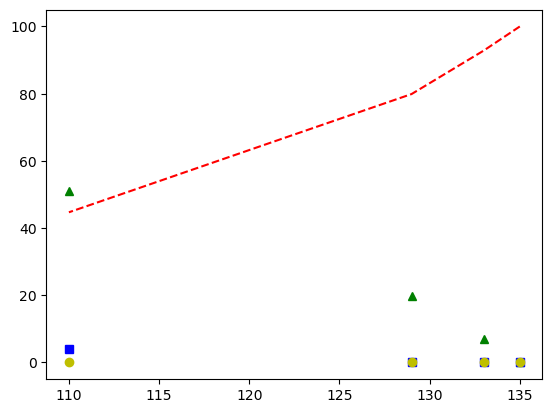

In [57]:
plt.plot(
    allsnaps, 
    proportions_per_type(proportions, 'n'), 
    'r--' ,
    allsnaps,  
    proportions_per_type(proportions, 'f'), 
    'g^' ,
    allsnaps,
    proportions_per_type(proportions, 'w'),
    'bs',
    allsnaps,
    proportions_per_type(proportions, 'v'),
    'yo'
)
plt.show()